In [1]:
def racnt(image, rad_interval=None, normalize=True):
    '''
    calculate the radial average power spectrum of an image
    Parameters
    ----------
    image : 2D numpy array
        The image to calculate the radial counts. Should be square.

    Returns
    -------
    X, Y : 1D numpy arrays
        X ranges from -0.5*sqrt(2), to 0.5*sqrt(2). Y is counts normalized to 1.
    '''

    import numpy as np

    x_sampling = np.linspace(-0.5, 0.5, image.shape[0])
    xx, yy = np.meshgrid(x_sampling, x_sampling)
    rad = np.sqrt(xx**2 + yy**2)
    if rad_interval is None:
        rad_interval = x_sampling[1] - x_sampling[0]

    X = np.arange(0, np.ceil(0.5/rad_interval)) * rad_interval
    Y = np.zeros(X.shape, dtype=np.float64)
    for i, x in enumerate(X):
        mask = np.logical_and(max(0, x - rad_interval/2) <= rad,
                              rad < x + rad_interval/2)
        Y[i] = np.sum(image[mask]) / (max(np.sum(mask), 1))
    if normalize:
        return X, Y / Y.max()
    else:
        return X, Y

## Diffraction Pattern Collected on Different Angle

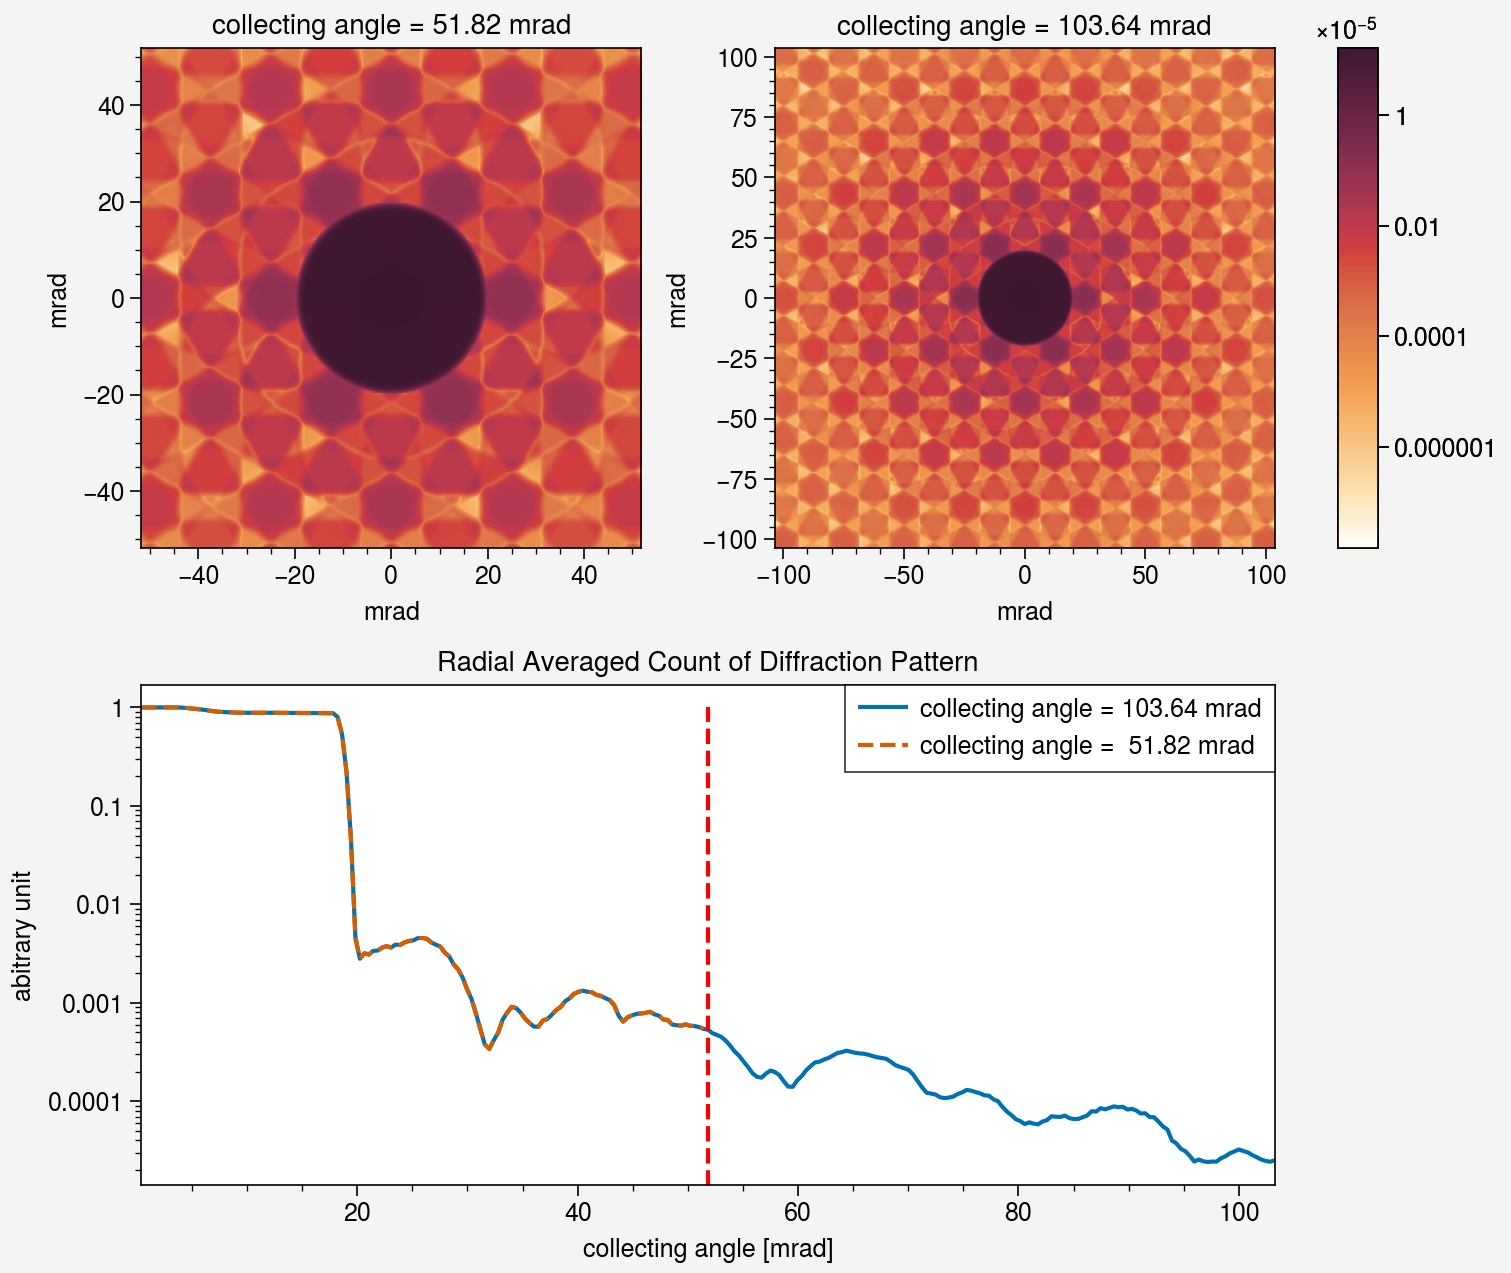

In [2]:
import numpy as np
import proplot as pplt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import h5py

with h5py.File(r'd:\Users\yiran.lu\Nextcloud\122 - WSe2 Simulation\IAMMeasurements_CrystalPotential.abtem.hdf5') as f:
    DP_00D = np.flipud(f['/array'][0, 0, :, :].T)
with h5py.File(r'd:\Users\yiran.lu\Nextcloud\128 - AAAnotherWSe2Simulation\IAMMeasurements_CrystalPotential.abtem.hdf5') as f:
    DP_00T = np.flipud(f['/array'][0, 0, :, :].T)

fig, (ax1, ax2, ax3) = pplt.subplots(
    array=[
        [1, 2],
        [3, 3]
    ],
    share=False
)
vmax = max(DP_00D.max(), DP_00T.max())
vmin = min(DP_00D.min(), DP_00T.min())

ax1.imshow(DP_00D, extent=[-51.8223742450, 51.8223742450, -51.8223742450, 51.8223742450],
            norm=LogNorm(),
           vmin=vmin, vmax=vmax)
ax1.format(title='collecting angle = 51.82 mrad')
m = ax2.imshow(DP_00T, extent=[-51.8223742450*2, 51.8223742450*2, -51.8223742450*2, 51.8223742450*2],
                norm=LogNorm(),
               vmin=vmin, vmax=vmax)
ax2.format(title='collecting angle = 103.64 mrad')
ax1.format(xlabel='mrad', ylabel='mrad')
ax2.format(xlabel='mrad', ylabel='mrad')
fig.colorbar(m, loc='r', row=1)

DP_00D_X, DP_00D_Y = racnt(DP_00D)
DP_00T_X, DP_00T_Y = racnt(DP_00T)

ax3.plot(DP_00T_X[1:] * 51.8223742450*2 * 2, DP_00T_Y[1:],
         label='collecting angle = 103.64 mrad')
ax3.plot(DP_00D_X[1:] * 51.8223742450 * 2, DP_00D_Y[1:], linestyle='--',
         label='collecting angle =  51.82 mrad')
ax3.format(yscale='log', title='Radial Averaged Count of Diffraction Pattern')
ax3.format(xlabel='collecting angle [mrad]', ylabel='abitrary unit')
ax3.legend(ncols=1, loc='upper right')

ax3.plot([51.8223742450, 51.8223742450], [0, 1], linestyle='--', color='red')

pplt.show()

## Reconstruction

In [3]:
# translate probe using Fourier translate
def translate(image, shift_x, shift_y, d=1):
    '''translate the image by pixels indicated by `shift_x` and `shift_y`.

    Parameters
    ==========
    image: 2D array
        the image to be translated
    shift_x, shift_y: float
        the number of pixels
    d: float
        sampling rate
    '''
    import numpy as np
    from numpy import fft

    image_fft = fft.fft2(image)
    y_fftfreq = fft.fftfreq(image.shape[0], d)
    x_fftfreq = fft.fftfreq(image.shape[1], d)
    xx_freq, yy_freq = np.meshgrid(x_fftfreq, y_fftfreq)

    shift_image_fft = image_fft * np.exp(-2j * np.pi * (xx_freq * shift_x + yy_freq * shift_y))
    return fft.ifft2(shift_image_fft)

### DM padding 1 Diffraction Pattern

In [14]:
import h5py
from numpy import fft

with h5py.File(r'd:\Users\yiran.lu\Nextcloud\122 - WSe2 Simulation\IAMMeasurements_CrystalPotential.abtem.hdf5') as f:
    DP_00D = np.flipud(f['/array'][11, 10, :, :].T)

with h5py.File(r'd:\Users\yiran.lu\Nextcloud\122 - WSe2 Simulation\dataset_025\results\task_SimWSe2_025_PtyPy_DM_padding_1\recons\ipykernel_launcher_DM_pycuda_0100.ptyr') as f:
    probe_wf = np.squeeze(f['/content/probe/Sscan_00G00/data'][()])
    trans_wf = np.squeeze(f['/content/obj/Sscan_00G00/data'][()])
    probe_wf = np.pad(probe_wf, ((0, trans_wf.shape[0] - probe_wf.shape[0]), (0, trans_wf.shape[1] - probe_wf.shape[1])))

dp_dm1 = np.flipud(np.abs(fft.fftshift(fft.fft2(translate(probe_wf, 2.75, 2.5, 0.4) * trans_wf[:probe_wf.shape[0], :probe_wf.shape[1]])))**2)
dp_dm1 /= dp_dm1.sum()

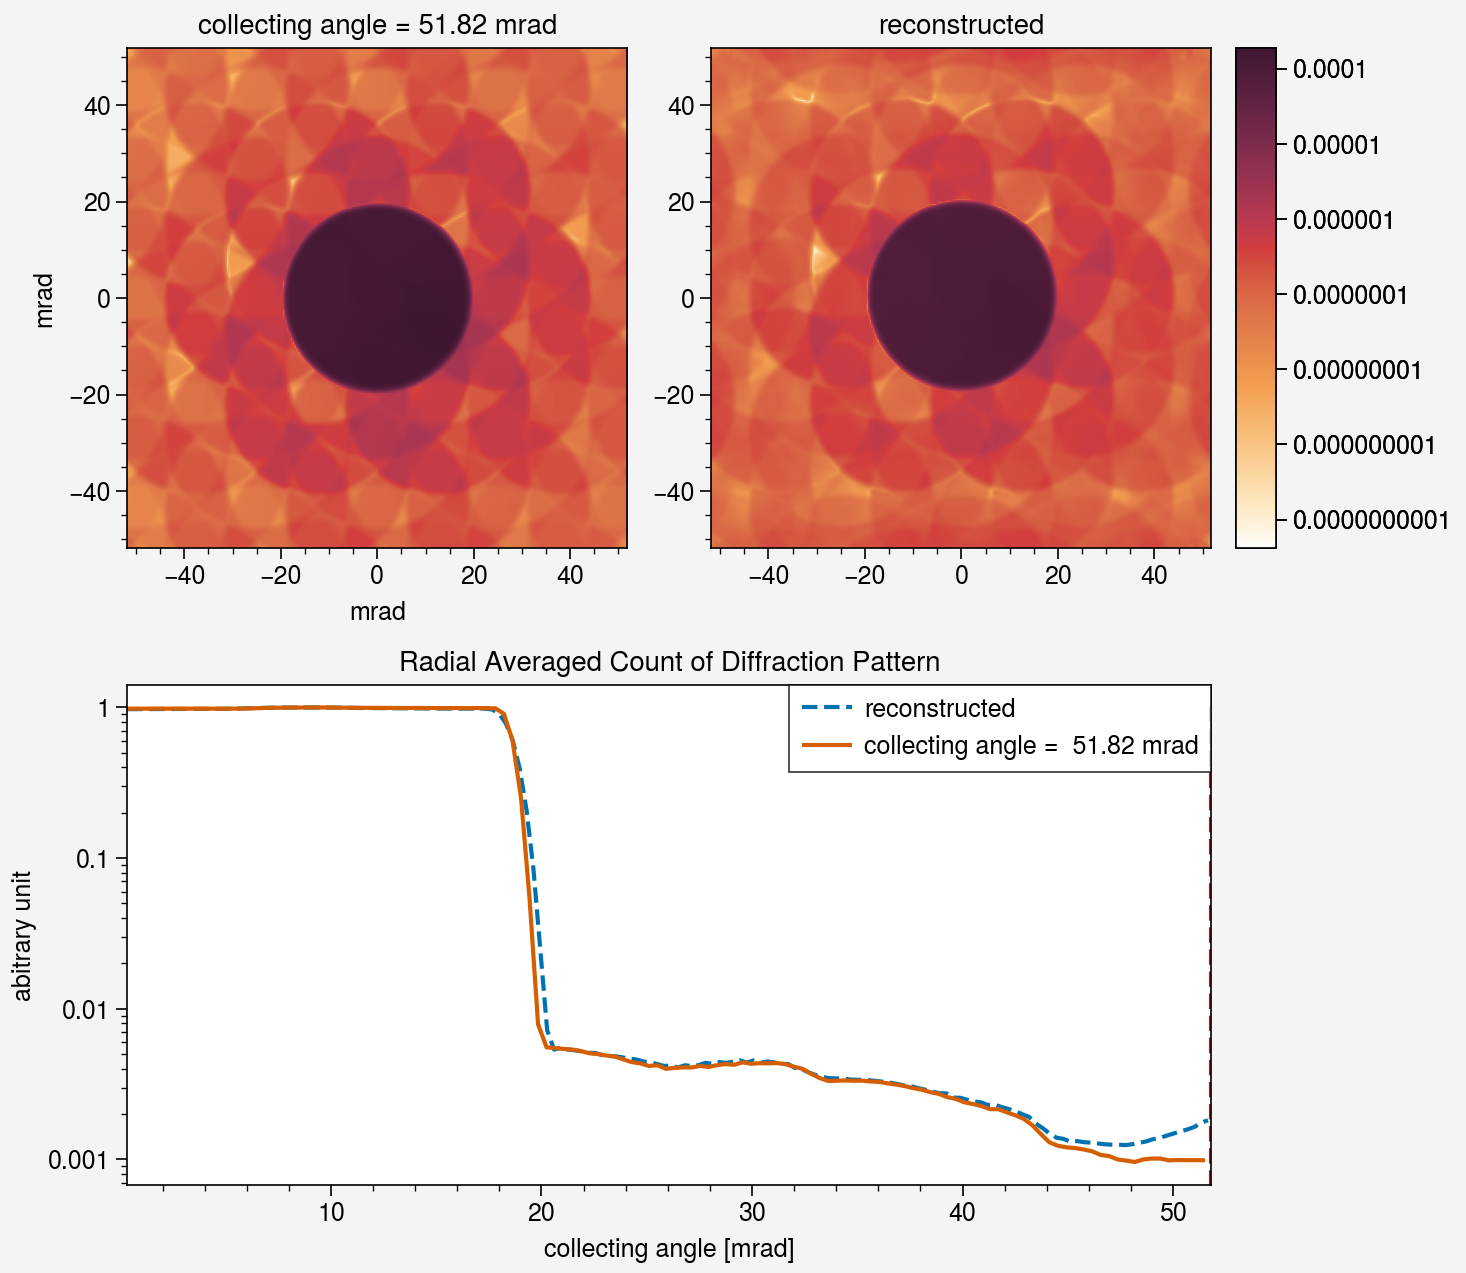

In [15]:
fig, (ax1, ax2, ax3) = pplt.subplots(
    array=[
        [1, 2],
        [3, 3]
    ],
    share=False
)
vmax = max(DP_00D.max(), dp_dm1.max())
vmin = min(DP_00D.min(), dp_dm1.min())

ax1.imshow(DP_00D, extent=[-51.8223742450, 51.8223742450, -51.8223742450, 51.8223742450],
            norm=LogNorm(),
           vmin=vmin, vmax=vmax)
ax1.format(title='collecting angle = 51.82 mrad')
m = ax2.imshow(dp_dm1, extent=[-51.8223742450, 51.8223742450, -51.8223742450, 51.8223742450],
                norm=LogNorm(),
               vmin=vmin, vmax=vmax)
ax2.format(title='reconstructed')
ax1.format(xlabel='mrad', ylabel='mrad')
fig.colorbar(m, loc='r', row=1)

DP_00D_X, DP_00D_Y = racnt(DP_00D)
dp_dm1_X, dp_dm1_Y = racnt(dp_dm1)

ax3.plot(dp_dm1_X[1:] * 51.8223742450 * 2, dp_dm1_Y[1:], linestyle='--',
         label='reconstructed')
ax3.plot(DP_00D_X[1:] * 51.8223742450 * 2, DP_00D_Y[1:],
         label='collecting angle =  51.82 mrad')
ax3.format(yscale='log', title='Radial Averaged Count of Diffraction Pattern')
ax3.format(xlabel='collecting angle [mrad]', ylabel='abitrary unit')
ax3.legend(ncols=1, loc='upper right')

ax3.plot([51.8223742450, 51.8223742450], [0, 1], linestyle='--', color='red')

pplt.show()

### DM padding 2 Diffraction Pattern

In [16]:
import h5py
from numpy import fft

with h5py.File(r'd:\Users\yiran.lu\Nextcloud\128 - AAAnotherWSe2Simulation\IAMMeasurements_CrystalPotential.abtem.hdf5') as f:
    DP_00T = np.flipud(f['/array'][11, 10, :, :].T)

with h5py.File(r'd:\Users\yiran.lu\Nextcloud\122 - WSe2 Simulation\dataset_025\results\task_SimWSe2_025_PtyPy_DM_padding_2\recons\ipykernel_launcher_DM_pycuda_0100.ptyr') as f:
    probe_wf = np.squeeze(f['/content/probe/Sscan_00G00/data'][()])
    trans_wf = np.squeeze(f['/content/obj/Sscan_00G00/data'][()])
    probe_wf = np.pad(probe_wf, ((0, trans_wf.shape[0] - probe_wf.shape[0]), (0, trans_wf.shape[1] - probe_wf.shape[1])))

dp_dm2 = np.flipud(np.abs(fft.fftshift(fft.fft2(translate(probe_wf, 2.75, 2.5, 0.2) * trans_wf[:probe_wf.shape[0], :probe_wf.shape[1]])))**2)
dp_dm2 /= dp_dm2.sum()

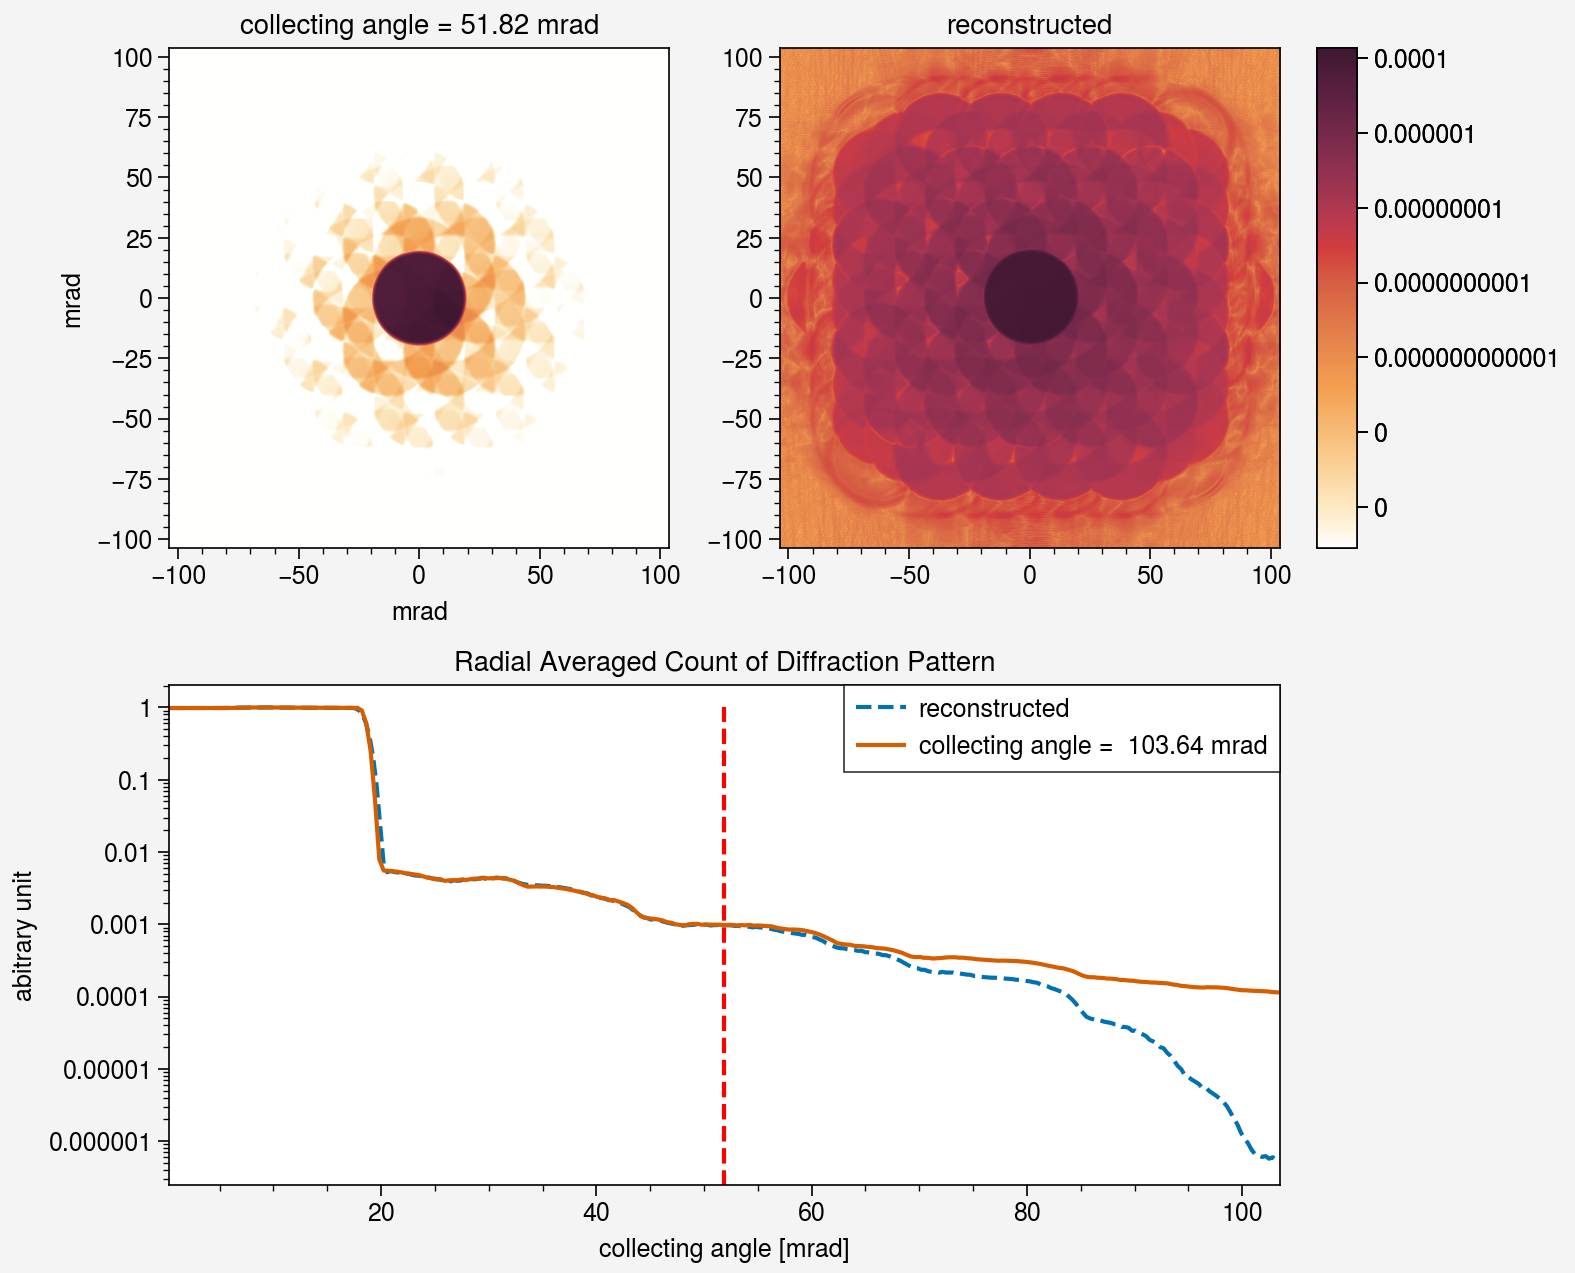

In [17]:
fig, (ax1, ax2, ax3) = pplt.subplots(
    array=[
        [1, 2],
        [3, 3]
    ],
    share=False
)
vmax = max(DP_00T.max(), dp_dm2.max())
vmin = min(DP_00T.min(), dp_dm2.min())

ax1.imshow(DP_00T, extent=[-51.8223742450*2, 51.8223742450*2, -51.8223742450*2, 51.8223742450*2],
            norm=LogNorm(),
           vmin=vmin, vmax=vmax)
ax1.format(title='collecting angle = 51.82 mrad')
m = ax2.imshow(dp_dm2, extent=[-51.8223742450*2, 51.8223742450*2, -51.8223742450*2, 51.8223742450*2],
                norm=LogNorm(),
               vmin=vmin, vmax=vmax)
ax2.format(title='reconstructed')
ax1.format(xlabel='mrad', ylabel='mrad')
fig.colorbar(m, loc='r', row=1)

DP_00T_X, DP_00T_Y = racnt(DP_00T)
dp_dm2_X, dp_dm2_Y = racnt(dp_dm2)

ax3.plot(dp_dm2_X[1:] * 51.8223742450*2 * 2, dp_dm2_Y[1:], linestyle='--',
         label='reconstructed')
ax3.plot(DP_00T_X[1:] * 51.8223742450*2 * 2, DP_00T_Y[1:],
         label='collecting angle =  103.64 mrad')
ax3.format(yscale='log', title='Radial Averaged Count of Diffraction Pattern')
ax3.format(xlabel='collecting angle [mrad]', ylabel='abitrary unit')
ax3.legend(ncols=1, loc='upper right')

ax3.plot([51.8223742450, 51.8223742450], [0, 1], linestyle='--', color='red')

pplt.show()

### DM padding 1 Diffraction Pattern Full Support

In [22]:
import h5py
from numpy import fft

with h5py.File(r'd:\Users\yiran.lu\Nextcloud\122 - WSe2 Simulation\IAMMeasurements_CrystalPotential.abtem.hdf5') as f:
    DP_00D = np.flipud(f['/array'][11, 10, :, :].T)

with h5py.File(r'd:\Users\yiran.lu\Nextcloud\122 - WSe2 Simulation\dataset_025\results\task_SimWSe2_025_PtyPy_DM_padding_1_full_support\recons\ipykernel_launcher_DM_pycuda_0100.ptyr') as f:
    probe_wf = np.squeeze(f['/content/probe/Sscan_00G00/data'][()])
    trans_wf = np.squeeze(f['/content/obj/Sscan_00G00/data'][()])
    probe_wf = np.pad(probe_wf, ((0, trans_wf.shape[0] - probe_wf.shape[0]), (0, trans_wf.shape[1] - probe_wf.shape[1])))

dp_dm1_f = np.flipud(np.abs(fft.fftshift(fft.fft2(translate(probe_wf, 2.75, 2.5, 0.4) * trans_wf[:probe_wf.shape[0], :probe_wf.shape[1]])))**2)
dp_dm1_f /= dp_dm1_f.sum()

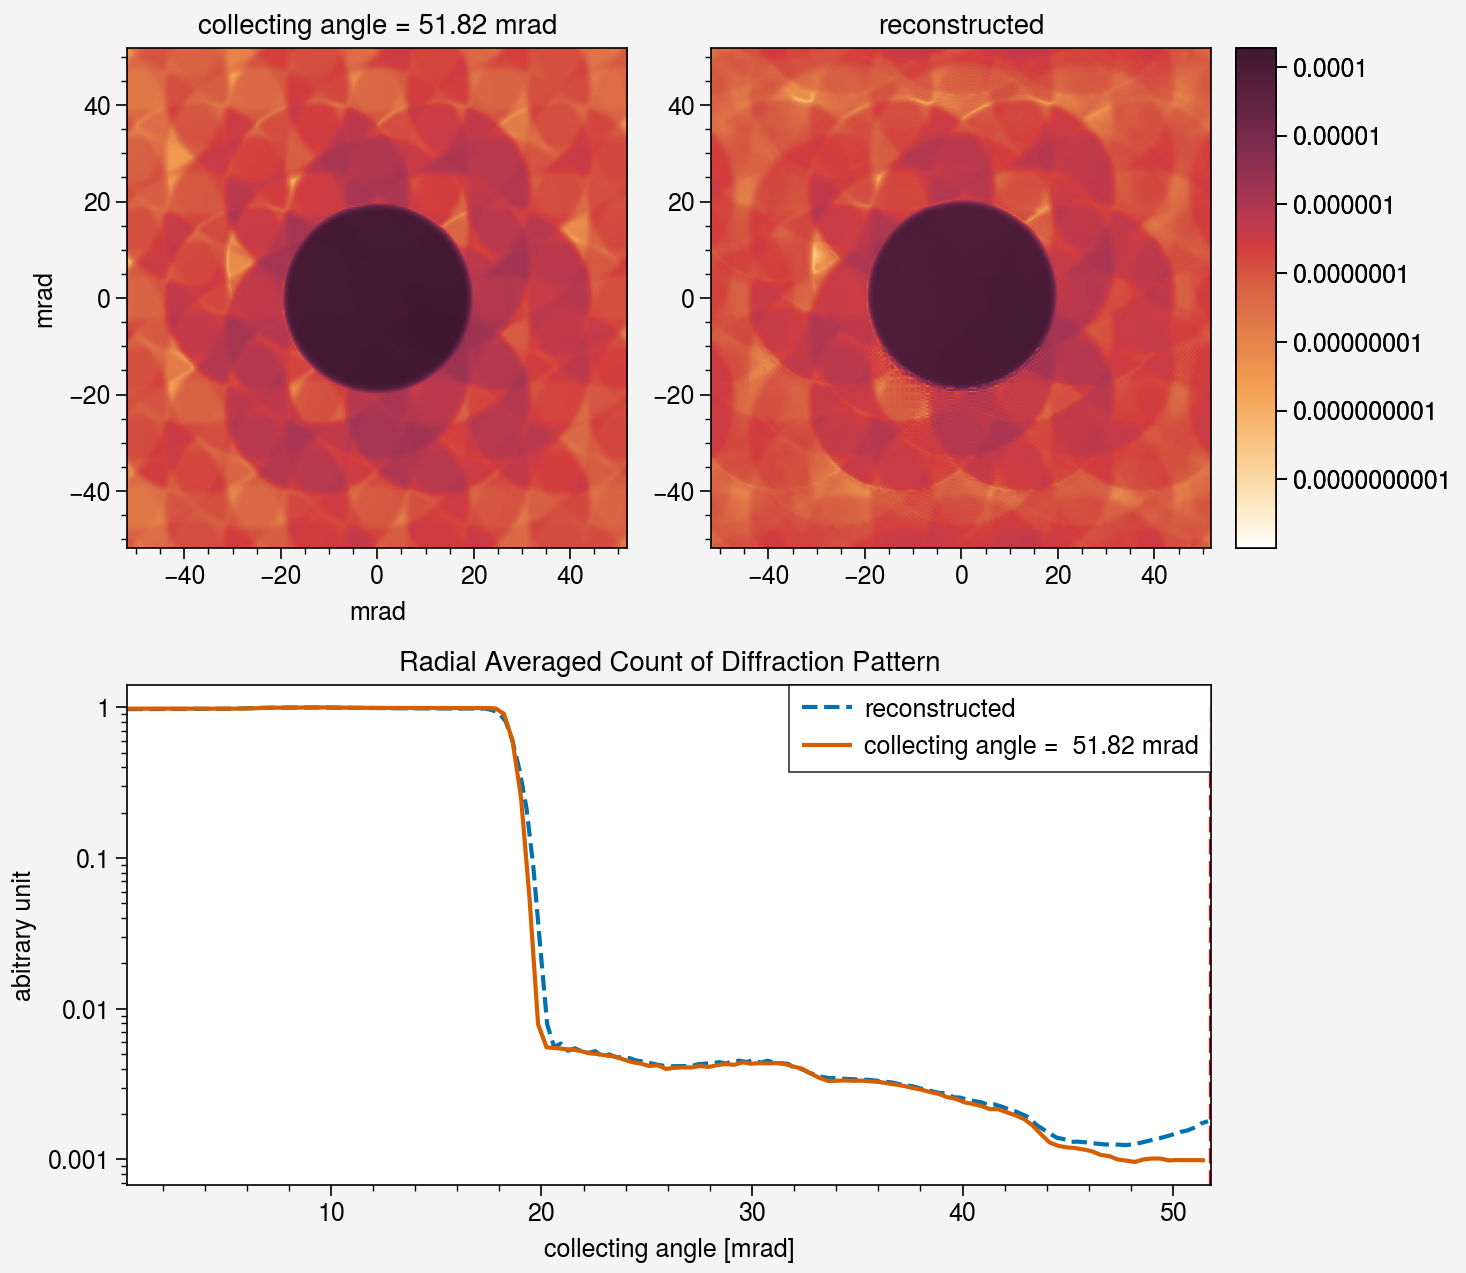

In [23]:
fig, (ax1, ax2, ax3) = pplt.subplots(
    array=[
        [1, 2],
        [3, 3]
    ],
    share=False
)
vmax = max(DP_00D.max(), dp_dm1_f.max())
vmin = min(DP_00D.min(), dp_dm1_f.min())

ax1.imshow(DP_00D, extent=[-51.8223742450, 51.8223742450, -51.8223742450, 51.8223742450],
            norm=LogNorm(),
           vmin=vmin, vmax=vmax)
ax1.format(title='collecting angle = 51.82 mrad')
m = ax2.imshow(dp_dm1_f, extent=[-51.8223742450, 51.8223742450, -51.8223742450, 51.8223742450],
                norm=LogNorm(),
               vmin=vmin, vmax=vmax)
ax2.format(title='reconstructed')
ax1.format(xlabel='mrad', ylabel='mrad')
fig.colorbar(m, loc='r', row=1)

DP_00D_X, DP_00D_Y = racnt(DP_00D)
dp_dm1_f_X, dp_dm1_f_Y = racnt(dp_dm1_f)

ax3.plot(dp_dm1_f_X[1:] * 51.8223742450 * 2, dp_dm1_f_Y[1:], linestyle='--',
         label='reconstructed')
ax3.plot(DP_00D_X[1:] * 51.8223742450 * 2, DP_00D_Y[1:],
         label='collecting angle =  51.82 mrad')
ax3.format(yscale='log', title='Radial Averaged Count of Diffraction Pattern')
ax3.format(xlabel='collecting angle [mrad]', ylabel='abitrary unit')
ax3.legend(ncols=1, loc='upper right')

ax3.plot([51.8223742450, 51.8223742450], [0, 1], linestyle='--', color='red')

pplt.show()


### DM padding 2 Diffraction Pattern Full Support

In [24]:
import h5py
from numpy import fft

with h5py.File(r'd:\Users\yiran.lu\Nextcloud\128 - AAAnotherWSe2Simulation\IAMMeasurements_CrystalPotential.abtem.hdf5') as f:
    DP_00T = np.flipud(f['/array'][11, 10, :, :].T)

with h5py.File(r'd:\Users\yiran.lu\Nextcloud\122 - WSe2 Simulation\dataset_025\results\task_SimWSe2_025_PtyPy_DM_padding_2_full_support\recons\ipykernel_launcher_DM_pycuda_0100.ptyr') as f:
    probe_wf = np.squeeze(f['/content/probe/Sscan_00G00/data'][()])
    trans_wf = np.squeeze(f['/content/obj/Sscan_00G00/data'][()])
    probe_wf = np.pad(probe_wf, ((0, trans_wf.shape[0] - probe_wf.shape[0]), (0, trans_wf.shape[1] - probe_wf.shape[1])))

dp_dm2_f = np.flipud(np.abs(fft.fftshift(fft.fft2(translate(probe_wf, 2.75, 2.5, 0.2) * trans_wf[:probe_wf.shape[0], :probe_wf.shape[1]])))**2)
dp_dm2_f /= dp_dm2_f.sum()

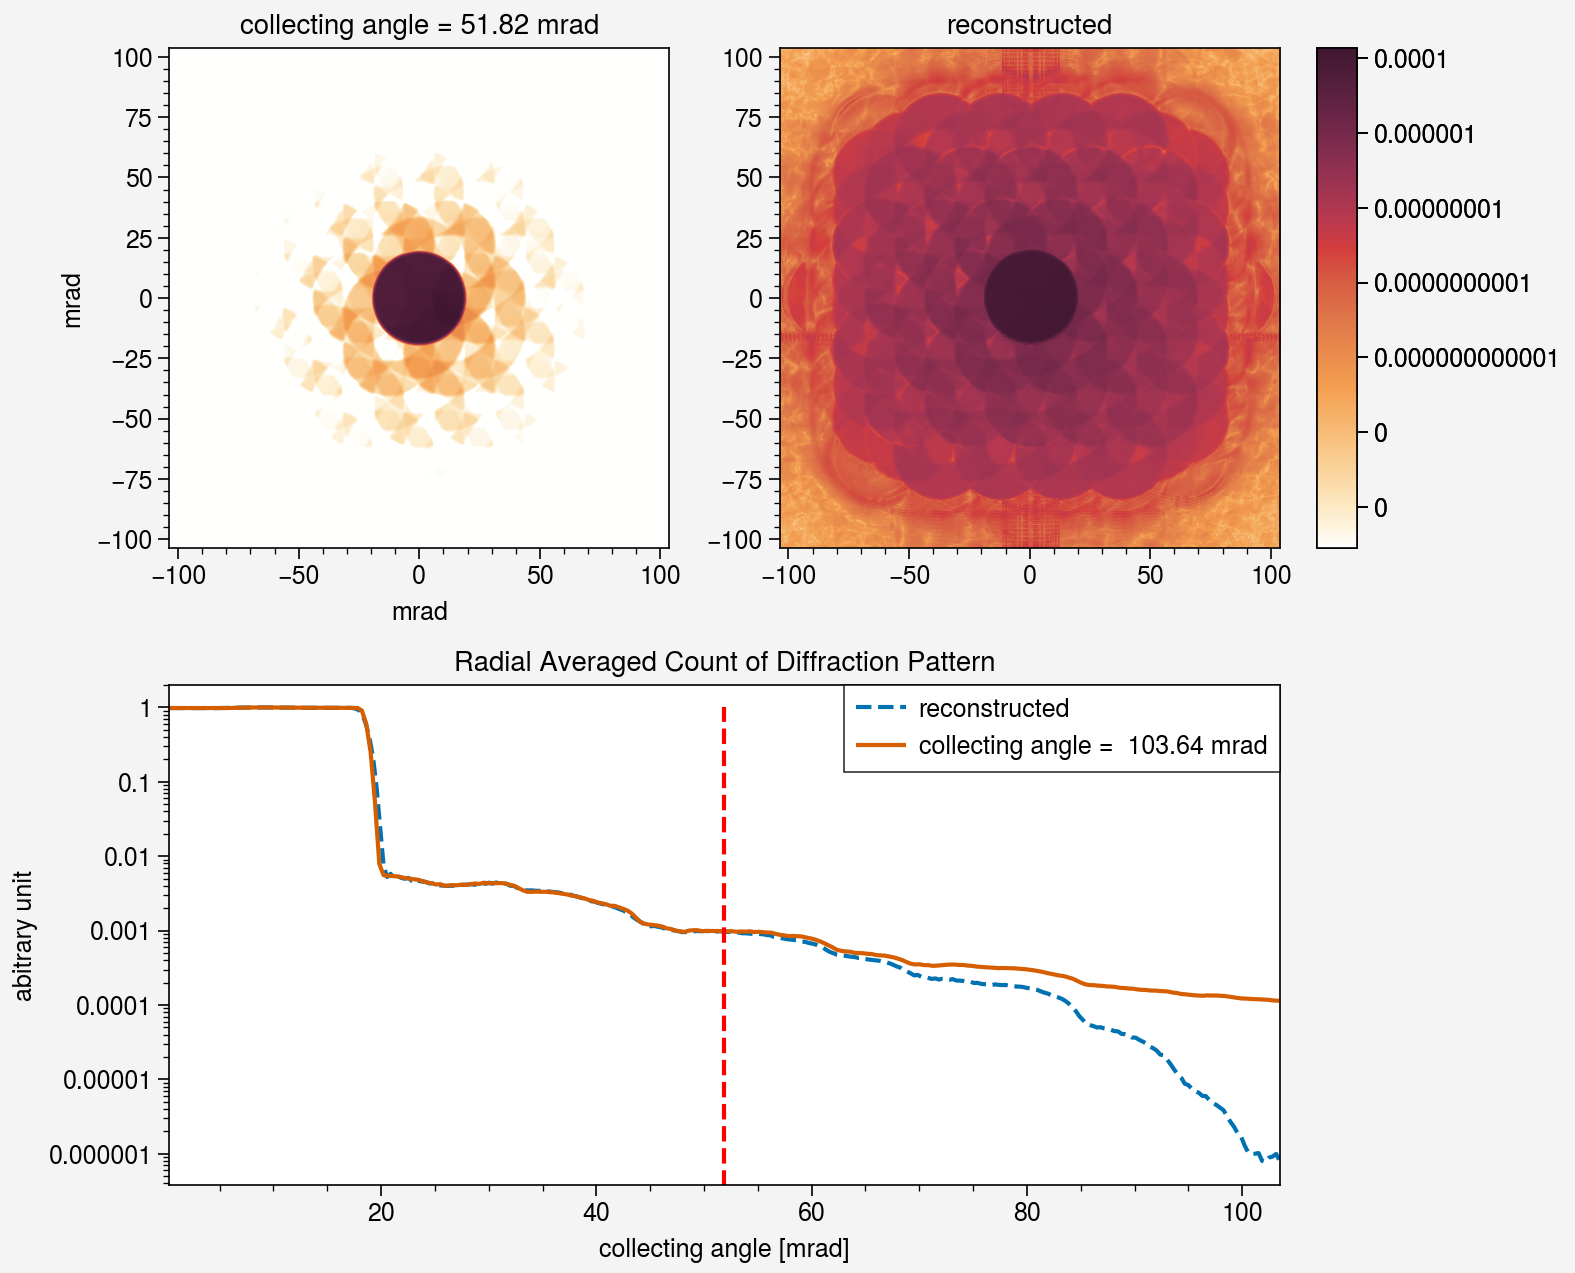

In [29]:
fig, (ax1, ax2, ax3) = pplt.subplots(
    array=[
        [1, 2],
        [3, 3]
    ],
    share=False
)
vmax = max(DP_00T.max(), dp_dm2.max())
vmin = min(DP_00T.min(), dp_dm2.min())

ax1.imshow(DP_00T, extent=[-51.8223742450*2, 51.8223742450*2, -51.8223742450*2, 51.8223742450*2],
            norm=LogNorm(),
           vmin=vmin, vmax=vmax)
ax1.format(title='collecting angle = 51.82 mrad')
m = ax2.imshow(dp_dm2_f, extent=[-51.8223742450*2, 51.8223742450*2, -51.8223742450*2, 51.8223742450*2],
                norm=LogNorm(),
               vmin=vmin, vmax=vmax)
ax2.format(title='reconstructed')
ax1.format(xlabel='mrad', ylabel='mrad')
fig.colorbar(m, loc='r', row=1)

DP_00T_X, DP_00T_Y = racnt(DP_00T)
dp_dm2_f_X, dp_dm2_f_Y = racnt(dp_dm2_f)

ax3.plot(dp_dm2_f_X[1:] * 51.8223742450*2 * 2, dp_dm2_f_Y[1:], linestyle='--',
         label='reconstructed')
ax3.plot(DP_00T_X[1:] * 51.8223742450*2 * 2, DP_00T_Y[1:],
         label='collecting angle =  103.64 mrad')
ax3.format(yscale='log', title='Radial Averaged Count of Diffraction Pattern')
ax3.format(xlabel='collecting angle [mrad]', ylabel='abitrary unit')
ax3.legend(ncols=1, loc='upper right')

ax3.plot([51.8223742450, 51.8223742450], [0, 1], linestyle='--', color='red')

pplt.show()

## Aggregation

c:\Users\yiran.lu\AppData\Local\mambaforge\envs\ResearchEnvs\lib\site-packages\proplot\axes\base.py:1566: UserWarning: AutoMinorLocator does not work with logarithmic scale
  bbox = super().get_tightbbox(renderer, *args, **kwargs)
c:\Users\yiran.lu\AppData\Local\mambaforge\envs\ResearchEnvs\lib\site-packages\proplot\gridspec.py:875: UserWarning: AutoMinorLocator does not work with logarithmic scale
  bbox = fig.get_tightbbox(renderer)
c:\Users\yiran.lu\AppData\Local\mambaforge\envs\ResearchEnvs\lib\site-packages\proplot\axes\base.py:1558: UserWarning: AutoMinorLocator does not work with logarithmic scale
  super().draw(renderer, *args, **kwargs)


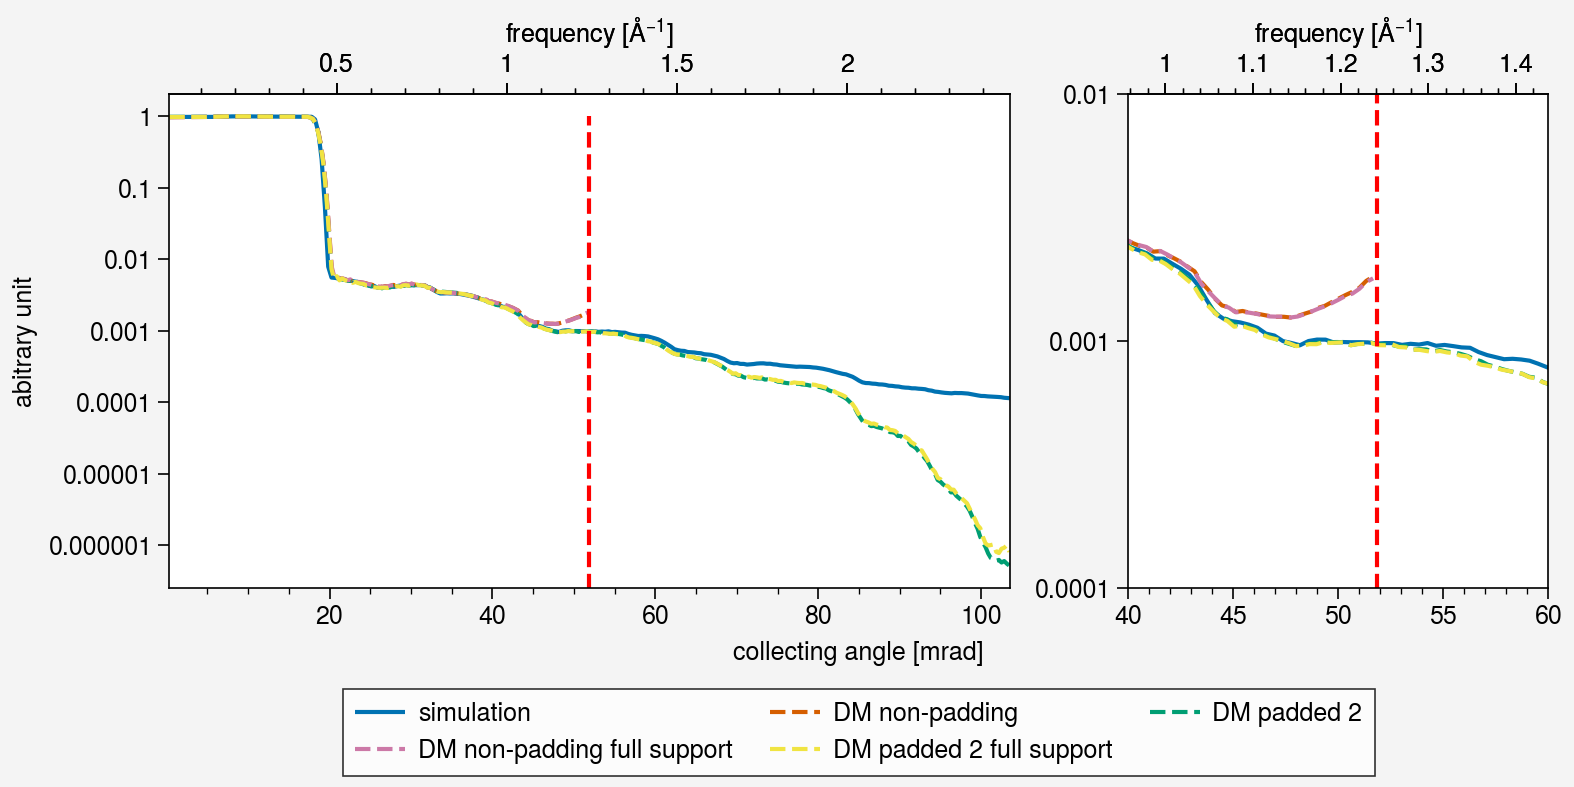

In [30]:
fig, (ax1, ax2) = pplt.subplots(
    nrows=1, ncols=2, wratios=(2, 1),
    share="labels",
    figsize=("20cm", "10cm"))

ax1.plot(DP_00T_X[1:] * 51.8223742450*2 * 2, DP_00T_Y[1:],
        label='simulation')
ax1.plot(dp_dm1_X[1:] * 51.8223742450 * 2, dp_dm1_Y[1:], linestyle='--',
        label='DM non-padding')
ax1.plot(dp_dm2_X[1:] * 51.8223742450*2 * 2, dp_dm2_Y[1:], linestyle='--',
        label='DM padded 2')
ax1.plot(dp_dm1_f_X[1:] * 51.8223742450 * 2, dp_dm1_f_Y[1:], linestyle='--',
        label='DM non-padding full support')
ax1.plot(dp_dm2_f_X[1:] * 51.8223742450*2 * 2, dp_dm2_f_Y[1:], linestyle='--',
        label='DM padded 2 full support')

ax1.format(yscale='log')
ax1.format(xlabel='collecting angle [mrad]', ylabel='abitrary unit')

ax1.plot([51.8223742450, 51.8223742450], [0, 1], linestyle='--', color='red')

ax1.dualx(lambda x: x*0.0239479883567794182, label='frequency [$\AA^{-1}$]')

ax2.plot(DP_00T_X[1:] * 51.8223742450*2 * 2, DP_00T_Y[1:],)
ax2.plot(dp_dm1_X[1:] * 51.8223742450 * 2, dp_dm1_Y[1:], linestyle='--',)
ax2.plot(dp_dm2_X[1:] * 51.8223742450*2 * 2, dp_dm2_Y[1:], linestyle='--',)
ax2.plot(dp_dm1_f_X[1:] * 51.8223742450 * 2, dp_dm1_f_Y[1:], linestyle='--',)
ax2.plot(dp_dm2_f_X[1:] * 51.8223742450*2 * 2, dp_dm2_f_Y[1:], linestyle='--',)

ax2.format(yscale='log')
ax2.format(xlabel='collecting angle [mrad]', ylabel='abitrary unit')
fig.legend(ncols=3, loc='bottom')

ax2.plot([51.8223742450, 51.8223742450], [0, 1], linestyle='--', color='red')

ax2.dualx(lambda x: x*0.0239479883567794182, label='frequency [$\AA^{-1}$]')

ax2.format(xlim=(40,60), ylim=(0.0001, 0.01))

pplt.show()